# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2019

## Project 3 - Triangular mesh generator



First we include some libraries and define utility functions from the lecture notes:

In [1]:
using PyPlot, LinearAlgebra, PyCall

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    tri = pyimport("matplotlib.tri")
    t = tri.Triangulation(first.(p), last.(p))
    t = Int64.(t.triangles .+ 1)
    t = [ t[i,:] for i = 1:size(t,1) ]
end

delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

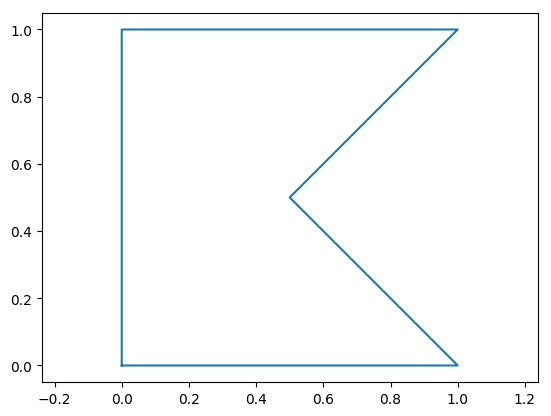

In [2]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

### Problem 1 - Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`. For example, in the test polygon above, the point $(0.6,0.3)$ is inside but $(0.8,0.3)$ is outside. For the algorithm, use the "Crossing number method" as described here: <http://geomalgorithms.com/a03-_inclusion.html>.

In [3]:
function inpolygon(p,pv) #return 1 if inside, 0 if outside
    intersections = 0
    for i = 1:length(pv) - 1
        x1 = pv[i][1]; x2 = pv[i + 1][1]
        y1 = pv[i][2]; y2 = pv[i + 1][2]
        if y2 > p[2] >= y1 || y2 <= p[2] < y1 
            m = (y2 - y1)/(x2 - x1)
            if (p[2] - y1)/m + x1 > p[1] #derived from some slope formula   
                intersections += 1
            end
        end
    end
    return intersections % 2
end

inpolygon (generic function with 1 method)

### Problem 2 - Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [4]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Array{Array{Float64,1},1}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

### Problem 2(a) - Triangle area

Write a function `tri_area(tri)` which returns the area of `tri`.

In [5]:
function tri_area(tri) #utilizes Heron's formula
    side = []
    for i = 1:3
        push!(side, sqrt((tri[i % 3 + 1][2] - tri[i][2])^2 + (tri[i % 3 + 1][1] - tri[i][1])^2))
    end
    s = sum(side)/2
    return sqrt(s*(s - side[1])*(s - side[2])*(s - side[3]))
end

tri_area (generic function with 1 method)

### Problem 2(b) - Triangle centroid

Write a function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [6]:
function tri_centroid(tri) 
    a = [first(tri[i]) for i = 1:3]; b = [last(tri[i]) for i = 1:3]
    return sum(a)/3,sum(b)/3
end

tri_centroid (generic function with 1 method)

### Problem 2(c) - Triangle circumcenter

Write a function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2>).

In [7]:
function tri_circumcenter(tri) #wiki formula
    A = tri[1]; B = tri[2]; C = tri[3]
    D = 2*(A[1]*(B[2] - C[2]) + B[1]*(C[2] - A[2]) + C[1]*(A[2] - B[2]))
    
    return U = ((A[1]^2 + A[2]^2)*(B[2] - C[2]) + (B[1]^2 + B[2]^2)*(C[2] - A[2]) + (C[1]^2 + C[2]^2)*(A[2] - B[2]))/D,
               ((A[1]^2 + A[2]^2)*(C[1] - B[1]) + (B[1]^2 + B[2]^2)*(A[1] - C[1]) + (C[1]^2 + C[2]^2)*(B[1] - A[1]))/D
end

tri_circumcenter (generic function with 1 method)

### Problem 3 - Mesh generator

Write a function with the syntax `p,t = pmesh(pv, hmax)` which generates a mesh `p,t` of the polygon `pv`, with triangle side lengths approximately `hmax`. Follow the algorithm as described below.

(a) The input `pv` is an array of points which defines the polygon. Note that the last point is equal to the first (a closed polygon).

(b) First, create node points `p` along each polygon segment, separated by a distance approximately equal to `hmax`. Make sure not to duplicate any nodes.

(c) Triangulate the domain using the `delaunay` function.

(d) Remove the triangles outside the polygon, by computing all the triangle centroids (using `tri_centroid`) and determining if they are inside (using `inpolygon`).

(e) Find the triangle with largest area $A$ (using `tri_area`). If $A>h_\mathrm{max}^2/2$, add the circumcenter of the triangle to the list of node points `p`.

(f) Repeat steps (c)-(d), that is, re-triangulate and remove outside triangles.

(g) Repeat steps (e)-(f) until no triangle area $A>h_\mathrm{max}^2/2$.

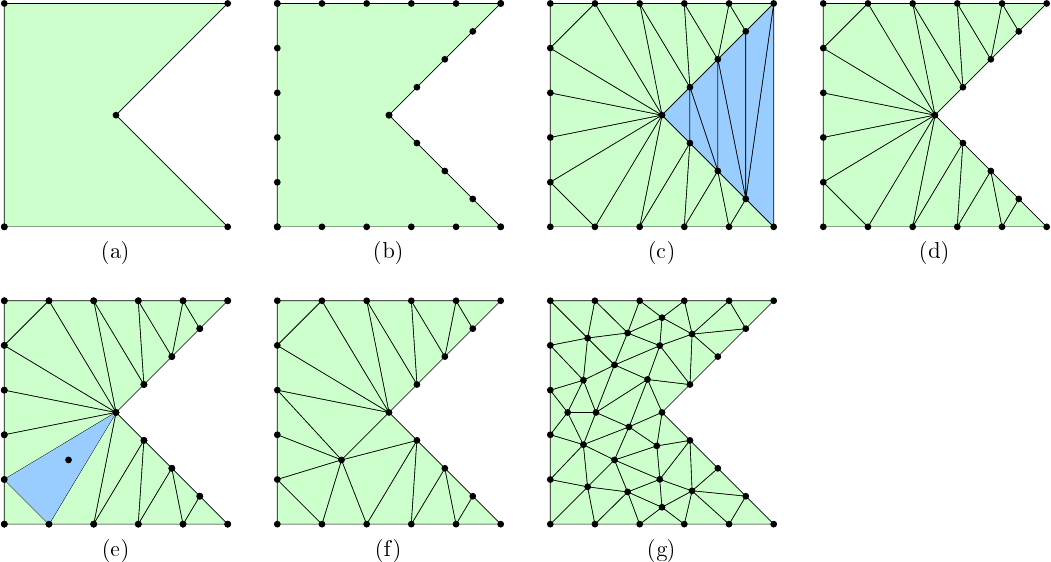

In [8]:
function pmesh(pv, hmax)
    p = []  #creates nodes
    for i = 1:length(pv) - 1
        x1 = pv[i][1]; x2 = pv[i + 1][1]
        y1 = pv[i][2]; y2 = pv[i + 1][2]
        dist = sqrt((y2 - y1)^2 + (x2 - x1)^2)
        n = round(dist/hmax)
        for j = 0:maximum([0,n-1])
            push!(p,[x1 + j*(x2 - x1)/n, y1 + j*(y2 - y1)/n])
        end
    end
    
    t = delaunay(p) #creates triangles
    inside = trues(length(t))
    
    for k = 1:length(t) #removes outside triangles
        a = p[t[k][1]]; b = p[t[k][2]]; c = p[t[k][3]]
        if inpolygon(tri_centroid([a,b,c]),pv) == 0
            inside[k] = false
        end
    end
    
    t = [t[k] for k = 1:length(t) if inside[k] == true] 
    area = [tri_area([p[t[l][1]], p[t[l][2]], p[t[l][3]]]) for l = 1:length(t)]
    A = maximum(area)
    
    while A > hmax^2/2 
        big = findmax(area)[2]         
        push!(p,tri_circumcenter([p[t[big][1]], p[t[big][2]], p[t[big][3]]]))
        t = delaunay(p)
        inside = trues(length(t))
                                  
        for k = 1:length(t) 
            a = p[t[k][1]]; b = p[t[k][2]]; c = p[t[k][3]]
            if inpolygon(tri_centroid([a,b,c]),pv) == 0
                inside[k] = false
            end
        end
    
        t = [t[k] for k = 1:length(t) if inside[k] == true] 
        area = [tri_area([p[t[l][1]], p[t[l][2]], p[t[l][3]]]) for l = 1:length(t)]
        A = maximum(area)      
    end
                
    return p,t
end

pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

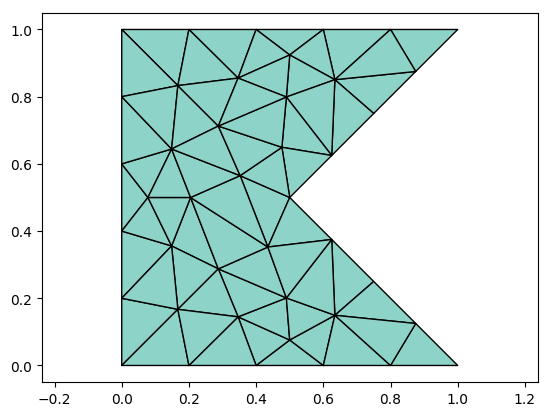

In [9]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

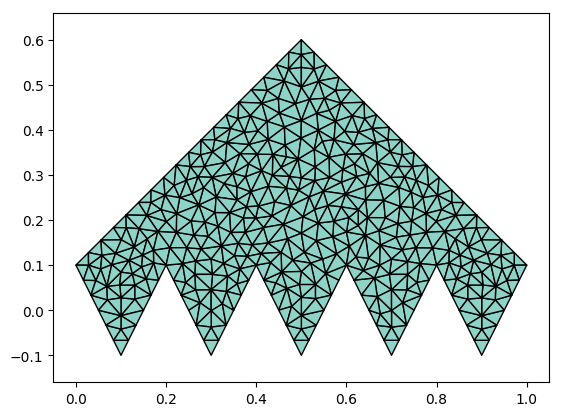

In [10]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)